In [43]:
import pandas as pd
import numpy as np
import logging
import os
import typhon
import netCDF_tools as nctools
from netCDF4 import Dataset
import filelists
from moisture_space import utils
import matplotlib.pyplot as plt
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING)
%matplotlib inline


In [44]:
def saturation_spec_hum(temp, pres):
    saturation_vapor_pres = typhon.physics.e_eq_mixed_mk(temp)
    epsilon = typhon.constants.molar_mass_water / typhon.constants.molar_mass_dry_air
    return epsilon * saturation_vapor_pres / (pres - (1 - epsilon) * saturation_vapor_pres)

def clausius_clapeyron_relation(temp):
    Lv = utils.mixed_heat_of_vaporization(temp)
    Rv = typhon.constants.gas_constant_water_vapor
    saturation_vapor_pres = typhon.physics.e_eq_mixed_mk(temp)
    return saturation_vapor_pres * Lv / Rv / (temp ** 2)
    
def clausius_clapeyron_relation_q(temp, pres, spec_hum):
    Lv = utils.mixed_heat_of_vaporization(temp)
    cp = typhon.constants.isobaric_mass_heat_capacity
    saturation_vapor_pres = typhon.physics.e_eq_mixed_mk(temp)
    epsilon = typhon.constants.molar_mass_water / typhon.constants.molar_mass_dry_air
    des_dT = clausius_clapeyron_relation(temp)
    rho = utils.calc_density_moist_air(pres, temp, spec_hum)
    #dqs_dT = epsilon / pres * des_dT + epsilon * saturation_vapor_pres / (pres ** 2) / rho / cp
    den = pres - (1 - epsilon) * saturation_vapor_pres
    dqs_dT = (epsilon * des_dT * den - epsilon * saturation_vapor_pres * (-1 / rho / cp - (1 - epsilon) * des_dT)) / (den ** 2)
    
    return dqs_dT

def sat_adjusted(temp, spec_hum, spec_cond, pres, num_iter=2):
    Lv = utils.mixed_heat_of_vaporization(temp)
    cp = typhon.constants.isobaric_mass_heat_capacity
    q_tot = spec_hum + spec_cond
    enthalpy_temp = temp + Lv / cp * spec_hum
    
    preliminary_temp = temp - Lv / cp * spec_cond
    preliminary_qs = saturation_spec_hum(preliminary_temp, pres)
    
    # adjustment for saturated case
    temp_adjusted, spec_hum_adjusted = newton_iteration_adjustment(temp, spec_hum, pres, num_iter=num_iter)
    spec_cond_adjusted = q_tot - spec_hum_adjusted
    
    # dinstinguisch between saturated and subsaturated case
    subsaturated = preliminary_qs > q_tot
    
    # adjustment for subsaturated case (overwrite respective values)
    temp_adjusted[subsaturated] = temp[subsaturated] - Lv[subsaturated] / cp * spec_cond[subsaturated]
    spec_hum_adjusted[subsaturated] = q_tot[subsaturated]
    spec_cond_adjusted[subsaturated] = 0.
    
    return temp_adjusted, spec_hum_adjusted, spec_cond_adjusted
    
def newton_iteration_adjustment(temp, spec_hum, pres, num_iter=2):
    Lv = utils.mixed_heat_of_vaporization(temp)
    cp = typhon.constants.isobaric_mass_heat_capacity
    enthalpy_temp = temp + Lv / cp * spec_hum
    dqs_dT = clausius_clapeyron_relation_q(temp, pres, spec_hum)
    
    for i in range(num_iter):
        print(i)
        print(np.where(temp < 0)[0].shape)
        dqs_dT_iter_before = dqs_dT.copy()
        dqs_dT = clausius_clapeyron_relation_q(temp, pres, spec_hum)
        temp_iter_before = temp.copy()
        temp = (enthalpy_temp - Lv / cp * (saturation_spec_hum(temp, pres) - temp * dqs_dT)) / (1 + Lv / cp * dqs_dT)
    
    spec_hum = saturation_spec_hum(temp_iter_before, pres) + (temp - temp_iter_before) * dqs_dT_iter_before #saturation_spec_hum(temp, pres)

    return temp, spec_hum

In [45]:
def adjustment_to_base(q_base, q_transp, qc_transp, temp_base, temp_transp, pres, num_iter=2):
    Lv = utils.mixed_heat_of_vaporization(temp_transp)
    cp = typhon.constants.isobaric_mass_heat_capacity
    
    delta_q = q_transp - q_base
    qs = saturation_spec_hum(temp_transp, pres)
    qs_base = saturation_spec_hum(temp_base, pres)
    
    moistening_transport = delta_q >= 0
    drying_transport = delta_q < 0
    supersat = np.logical_and(q_base >= qs_base, q_transp >= qs)
    supersat_by_transp = np.logical_and(q_base < qs_base, q_transp >= qs)
    subsat = q_transp < qs
    subsat_by_transp = np.logical_and(q_base >= qs_base, q_transp < qs)
    #enough_cond = np.abs(delta_q) <= qc_transp
    cond = qc_transp > 0.
    
    moistening_supersat = np.logical_and(moistening_transport, supersat)
    moistening_supersat_by_transp = np.logical_and(moistening_transport, supersat_by_transp)
    drying_subsat = np.logical_and(drying_transport, subsat)
    #drying_subsat_enough_cond = np.logical_and(drying_subsat, enough_cond)
    #drying_subsat_not_enough_cond = np.logical_and(drying_subsat, np.logical_not(enough_cond))
    drying_subsat_cond = np.logical_and(drying_subsat, cond)
    
    q_adj = q_transp.copy()
    temp_adj = temp_transp.copy()
    qc_adj = qc_transp.copy()
    
    sat = q_base > qs
    sat_transp = q_transp > qs
    
    q_adj[moistening_supersat] = q_transp[moistening_supersat] - delta_q[moistening_supersat]
    temp_adj[moistening_supersat] = temp_transp[moistening_supersat] + Lv[moistening_supersat] / cp * delta_q[moistening_supersat]
    qc_adj[moistening_supersat] = qc_transp[moistening_supersat] + delta_q[moistening_supersat]
    
    temp_adj[moistening_supersat_by_transp], q_adj[moistening_supersat_by_transp], qc_adj[moistening_supersat_by_transp] = sat_adjusted(
        temp_transp[moistening_supersat_by_transp],
        q_transp[moistening_supersat_by_transp],
        qc_transp[moistening_supersat_by_transp], 
        pres[moistening_supersat_by_transp], num_iter=2
    )
    
    temp_adj[drying_subsat_cond], q_adj[drying_subsat_cond], qc_adj[drying_subsat_cond] = sat_adjusted(
        temp_transp[drying_subsat_cond],
        q_transp[drying_subsat_cond],
        qc_transp[drying_subsat_cond],
        pres[drying_subsat_cond], num_iter=2
    )
    
    drying_subsat_not_enough_cond = qc_adj < 0.
    
    q_adj[drying_subsat_not_enough_cond] = q_transp[drying_subsat_not_enough_cond] + qc_transp[drying_subsat_not_enough_cond]
    temp_adj[drying_subsat_not_enough_cond] = temp_transp[drying_subsat_not_enough_cond] + Lv[drying_subsat_not_enough_cond] / cp * qc_transp[drying_subsat_not_enough_cond]
    qc_adj[drying_subsat_not_enough_cond] = 0.
    
    overadjusted = np.abs(q_adj - q_transp) > np.abs(q_base - q_transp)
    q_adj[overadjusted] = q_base[overadjusted]
    temp_adj[overadjusted] = temp_transp[overadjusted] + Lv[overadjusted] / cp * delta_q[overadjusted]
    qc_adj[overadjusted] = qc_transp[overadjusted] + delta_q[overadjusted]
    print(np.sum(overadjusted))
    return q_adj, temp_adj, qc_adj
    

In [46]:
model = 'ICON'
run = '2.5km'
time_period = ["2016-08-10", "2016-09-08"]
data_dir = "/mnt/lustre02/work/mh1126/m300773/DYAMOND"
num_samples = 10000000
sample_days = 'all'

In [47]:
time = pd.date_range(time_period[0], time_period[1], freq='1D')
start_date = time[0].strftime("%m%d")
end_date = time[-1].strftime("%m%d")

input_variables = ['TQR', 'A_T_h', 'A_T_v', 'DT_Dt_h', 'DT_Dt_v', 'A_QV_h', 'A_QV_v', 'A_QI_h', 'A_QI_v', 'A_QC_h', 'A_QC_v', 'A_RH_h', 'A_RH_v', 'DRH_Dt_h', 'DRH_Dt_v', 'RH', 'QV', 'QC', 'QI', 'PRES', 'TEMP']
filename = '{}-{}_{}_sample_{}_{}-{}.nc'
filenames = {}
for var in input_variables:
    filenames[var] = os.path.join(data_dir, model, 'random_samples',
                                 filename.format(model, run, var, num_samples, start_date, end_date)
                                 )
outname = filename.format(model, run, 'DRH_Dt_c', num_samples, start_date, end_date)

# ACHTUNG: Im moment werden die untersten Level nicht eingelesen
profiles = {}
for var in input_variables:
    print(var)
    with Dataset(filenames[var]) as ds:
        if var == 'TQR':
            profiles[var] = ds.variables[var][::2].filled(np.nan)
        else:
            profiles[var] = ds.variables[var][20:, ::2].filled(np.nan)

TQR
A_T_h
A_T_v
DT_Dt_h
DT_Dt_v
A_QV_h
A_QV_v
A_QI_h
A_QI_v
A_QC_h
A_QC_v
A_RH_h
A_RH_v
DRH_Dt_h
DRH_Dt_v
RH
QV
QC
QI
PRES
TEMP


In [48]:
heightfile = filelists.get_path2targetheightfile(model, data_dir)
with Dataset(heightfile) as ds:
        height = ds.variables['target_height'][20:].filled(np.nan)

In [49]:
dt = 30# seconds
num_iter = 1
q_sat = saturation_spec_hum(profiles['TEMP'], profiles['PRES'])
temp_transp = profiles['TEMP'] + (profiles['A_T_h'] + profiles['A_T_v'] + profiles['DT_Dt_h'] + profiles['DT_Dt_v']) * dt
q_transp = profiles['QV'] + (profiles['A_QV_h'] + profiles['A_QV_v']) * dt
pres = profiles['PRES']
rh_transp = utils.spec_hum2rel_hum(q_transp, temp_transp, pres)##profiles['RH'] + (profiles['A_RH_h'] + profiles['A_RH_v'] + profiles['DRH_Dt_h'] + profiles['DRH_Dt_v']) * dt
dr_dt_transp = (rh_transp - profiles['RH']) / dt#profiles['A_RH_h'] + profiles['A_RH_v'] + profiles['DRH_Dt_h'] + profiles['DRH_Dt_v']
dq_dt_transp = (q_transp - profiles['QV']) / dt
qic_tot = profiles['QI'] + profiles['QC']
unsat = profiles['RH'] < 1.
qic_tot[unsat] = 0.
qic_transp = qic_tot + (profiles['A_QI_h'] + profiles['A_QI_v'] + profiles['A_QC_h'] + profiles['A_QC_v']) * dt
qic_transp[qic_transp < 0] = 0.

In [50]:
# Simplified method: Adjustment to base state where possible
q_adjusted, temp_adjusted, qic_adjusted = adjustment_to_base(profiles['QV'], q_transp, qic_transp, profiles['TEMP'], temp_transp, pres)

rh_adjusted = utils.spec_hum2rel_hum(q_adjusted, temp_adjusted, pres, phase='mixed')
dq_dt = (q_adjusted - q_transp) / dt 
dr_dt = (rh_adjusted - rh_transp) / dt 

0
(0,)
1
(0,)
0
(0,)
1
(0,)
263762


In [51]:
#wrong_values = np.abs(dr_dt) > 0.005
#dr_dt[wrong_values] = np.nan

num_percs = 50
splitted_array = np.array_split(dr_dt, num_percs, axis=1)
dr_dt_mean = np.asarray([np.nanmean(a, axis=1) for a in splitted_array])
splitted_array = np.array_split(dq_dt, num_percs, axis=1)
dq_dt_mean = np.asarray([np.nanmean(a, axis=1) for a in splitted_array])
splitted_array = np.array_split(profiles['QV'], num_percs, axis=1)
q_mean = np.asarray([np.nanmean(a, axis=1) for a in splitted_array])
splitted_array = np.array_split(qic_transp, num_percs, axis=1)
qic_mean = np.asarray([np.nanmean(a, axis=1) for a in splitted_array])
splitted_array = np.array_split(qic_adjusted, num_percs, axis=1)
qic_adjusted_mean = np.asarray([np.nanmean(a, axis=1) for a in splitted_array])
high_adv = np.abs(profiles['A_QV_h']/profiles['QV']) > 0.001
profiles['A_QV_h'][high_adv] = np.nan
splitted_array = np.array_split(profiles['A_QV_h'], num_percs, axis=1)
aqvh_mean = np.asarray([np.nanmean(a, axis=1) for a in splitted_array])

In [ ]:
plt.style.use(typhon.plots.styles.get('typhon'))
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.contourf(np.arange(num_percs) * 2, height * 1e-3, dr_dt_mean.T * 1e2 * 24 * 60 * 60, np.arange(-100, 101, 5), cmap='difference_r', extend='both')
ax.set_ylim(0, 17.5)
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('Height / km')
#ax.set_title(f'Timestep: {dt} sec')
fig.colorbar(im, label='RH tendency / (% d $^{-1}$)')
plt.savefig('plots_seminar/RH_tendency_condensation.pdf', dpi=400)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
contours = np.arange(-100, 101, 10)
im = ax.contourf(np.arange(num_percs) * 2, height * 1e-3, (dq_dt_mean.T/q_mean.T)* 1e2 * 24 * 60 * 60, contours, cmap='difference_r', extend='both')
ax.set_ylim(0, 17.5)
ax.set_xlabel('P(IWV)')
ax.set_ylabel('Height / km')
ax.set_title(f'Timestep: {dt} sec')
fig.colorbar(im, label='q tendency / (% d $^{-1}$)')

In [50]:
import pickle
outname = f'/mnt/lustre02/work/mh1126/m300773/DYAMOND/ICON/random_samples/{model}_drdt_cond.pkl'
with open(outname, 'wb' ) as outfile:
    pickle.dump(dr_dt_mean, outfile)
    
outname = f'/mnt/lustre02/work/mh1126/m300773/DYAMOND/ICON/random_samples/{model}_dqdt_cond.pkl'
with open(outname, 'wb' ) as outfile:
    pickle.dump(dq_dt_mean, outfile)

In [34]:
q_base = profiles['QV']
qic_base = qic_tot
temp_base = profiles['TEMP']

delta_q = q_transp - q_base
qs = saturation_spec_hum(temp_transp, pres)
qs_base = saturation_spec_hum(temp_base, pres)

moistening_transport = delta_q >= 0
drying_transport = delta_q < 0
supersat = q_transp >= qs
supersat_before = np.logical_and(q_base >= qs_base, q_transp >= qs)
supersat_by_transp = np.logical_and(q_base < qs_base, q_transp >= qs)
subsat = q_transp < qs
subsat_by_transp = np.logical_and(q_base >= qs_base, q_transp < qs)
cond = qic_transp > 0.
evap_tot = np.logical_and(qic_transp > 0, qic_adjusted <= 0)
evap_part = np.logical_and(qic_transp > 0, qic_adjusted > 0)
q_crit = q_transp > qs#np.logical_and(q_transp > qs, q_transp <= (qs + 0.1 * q_transp))
cond_crit = np.logical_and(qic_transp > 0., q_crit)

moistening_subsat = np.logical_and(moistening_transport, subsat)
moistening_supersat = np.logical_and(moistening_transport, supersat)
moistening_supersat_before = np.logical_and(moistening_transport, supersat_before)
moistening_supersat_by_transp = np.logical_and(moistening_transport, supersat_by_transp)
drying_subsat = np.logical_and(drying_transport, subsat)
drying_subsat_by_transp = np.logical_and(drying_transport, subsat_by_transp)
drying_subsat_cond = np.logical_and(drying_subsat, cond)
drying_subsat_evap_tot = np.logical_and(drying_subsat, evap_tot)
drying_subsat_evap_part = np.logical_and(drying_subsat, evap_part)
drying_subsat_cond_crit = np.logical_and(drying_subsat, cond_crit)
drying_subsat_no_cond = np.logical_and(drying_subsat, np.logical_not(cond))

In [35]:
num_percs = 50
splitted_array = np.array_split(moistening_subsat, num_percs, axis=1)
moistening_subsat_perc = np.asarray([np.sum(a, axis=1) / a.shape[1] for a in splitted_array])
splitted_array = np.array_split(supersat, num_percs, axis=1)
supersat_perc = np.asarray([np.sum(a, axis=1) / a.shape[1] for a in splitted_array])
splitted_array = np.array_split(moistening_supersat, num_percs, axis=1)
moistening_supersat_perc = np.asarray([np.sum(a, axis=1) / a.shape[1] for a in splitted_array])
splitted_array = np.array_split(moistening_supersat_before, num_percs, axis=1)
moistening_supersat_before_perc = np.asarray([np.sum(a, axis=1) / a.shape[1] for a in splitted_array])
splitted_array = np.array_split(moistening_supersat_by_transp, num_percs, axis=1)
moistening_supersat_by_transp_perc = np.asarray([np.sum(a, axis=1) / a.shape[1] for a in splitted_array])
splitted_array = np.array_split(drying_subsat, num_percs, axis=1)
drying_subsat_perc = np.asarray([np.sum(a, axis=1) / a.shape[1] for a in splitted_array])
splitted_array = np.array_split(drying_subsat_by_transp, num_percs, axis=1)
drying_subsat_by_transp_perc = np.asarray([np.sum(a, axis=1) / a.shape[1] for a in splitted_array])
splitted_array = np.array_split(drying_subsat_cond, num_percs, axis=1)
drying_subsat_cond_perc = np.asarray([np.sum(a, axis=1) / a.shape[1] for a in splitted_array])
splitted_array = np.array_split(drying_subsat_cond_crit, num_percs, axis=1)
drying_subsat_cond_crit_perc = np.asarray([np.sum(a, axis=1) / a.shape[1] for a in splitted_array])
splitted_array = np.array_split(drying_subsat_no_cond, num_percs, axis=1)
drying_subsat_no_cond_perc = np.asarray([np.sum(a, axis=1) / a.shape[1] for a in splitted_array])
splitted_array = np.array_split(drying_subsat_evap_tot, num_percs, axis=1)
drying_subsat_evap_tot_perc = np.asarray([np.sum(a, axis=1) / a.shape[1] for a in splitted_array])
splitted_array = np.array_split(drying_subsat_evap_part, num_percs, axis=1)
drying_subsat_evap_part_perc = np.asarray([np.sum(a, axis=1) / a.shape[1] for a in splitted_array])
splitted_array = np.array_split(cond_crit, num_percs, axis=1)
cond_crit_perc = np.asarray([np.sum(a, axis=1) / a.shape[1] for a in splitted_array])

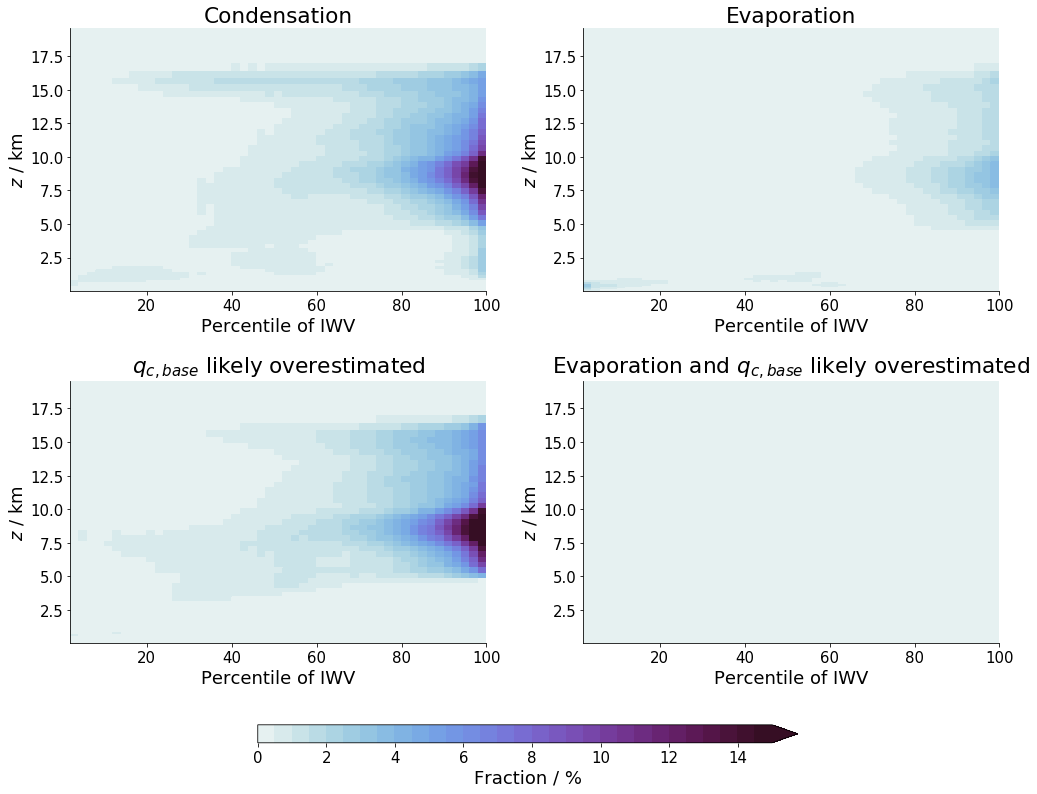

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
perc_values = np.arange(2, 100.5, 2)
im = ax[0, 0].pcolor(perc_values, height * 1e-3, moistening_supersat_perc.T * 100, cmap=plt.get_cmap('density', 30),
              vmin=0, vmax=15)
im = ax[0, 1].pcolor(perc_values, height * 1e-3, drying_subsat_cond_perc.T * 100, cmap=plt.get_cmap('density', 30),
              vmin=0, vmax=15)
im = ax[1, 0].pcolor(perc_values, height * 1e-3, cond_crit_perc.T * 100, cmap=plt.get_cmap('density', 30), vmin=0, vmax=15)
im = ax[1, 1].pcolor(perc_values, height * 1e-3, drying_subsat_cond_crit_perc.T * 100, cmap=plt.get_cmap('density', 30), vmin=0, vmax=15)

ax[0, 0].set_title('Condensation')
ax[0, 1].set_title('Evaporation')
ax[1, 0].set_title(r'$q_{c, base}$ likely overestimated')
ax[1, 1].set_title(r'Evaporation and $q_{c, base}$ likely overestimated')

ax = ax.ravel()
for i in range(4):
    ax[i].set_xlabel('Percentile of IWV')
    ax[i].set_ylabel('$z$ / km')

plt.tight_layout()

cb_ax = fig.add_axes([0.25, -0.05, 0.5, 0.025])
fig.colorbar(im, cax=cb_ax, orientation='horizontal', label='Fraction / %', extend='max')

plt.savefig("plots_seminar/fractions_adjustment.pdf", dpi=400, bbox_inches='tight')

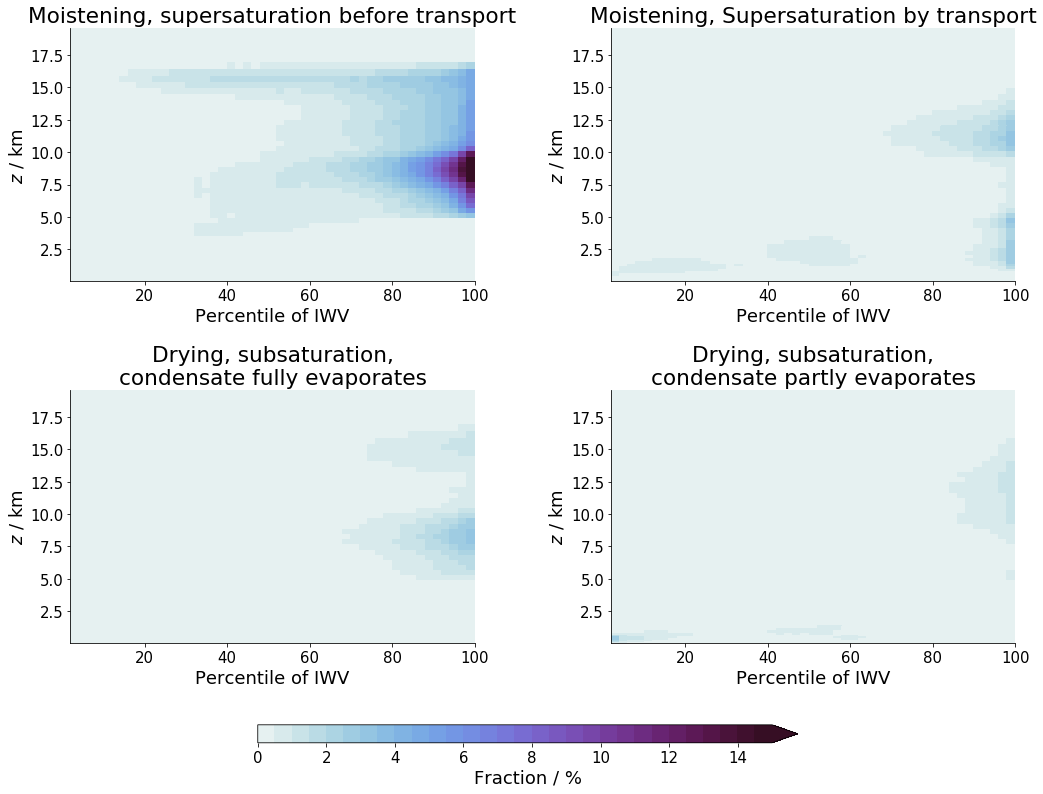

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
perc_values = np.arange(2, 100.5, 2)
im = ax[0, 0].pcolor(perc_values, height * 1e-3, moistening_supersat_before_perc.T * 100, cmap=plt.get_cmap('density', 30),
              vmin=0, vmax=15)
im = ax[0, 1].pcolor(perc_values, height * 1e-3, moistening_supersat_by_transp_perc.T * 100, cmap=plt.get_cmap('density', 30),
              vmin=0, vmax=15)
im = ax[1, 0].pcolor(perc_values, height * 1e-3, drying_subsat_evap_tot_perc.T * 100, cmap=plt.get_cmap('density', 30), vmin=0, vmax=15)
im = ax[1, 1].pcolor(perc_values, height * 1e-3, drying_subsat_evap_part_perc.T * 100, cmap=plt.get_cmap('density', 30), vmin=0, vmax=15)

ax[0, 0].set_title('Moistening, supersaturation before transport')
ax[0, 1].set_title('Moistening, Supersaturation by transport')
ax[1, 0].set_title('Drying, subsaturation,\ncondensate fully evaporates')
ax[1, 1].set_title('Drying, subsaturation,\ncondensate partly evaporates')

ax = ax.ravel()
for i in range(4):
    ax[i].set_xlabel('Percentile of IWV')
    ax[i].set_ylabel('$z$ / km')

plt.tight_layout()

cb_ax = fig.add_axes([0.25, -0.05, 0.5, 0.025])
fig.colorbar(im, cax=cb_ax, orientation='horizontal', label='Fraction / %', extend='max')

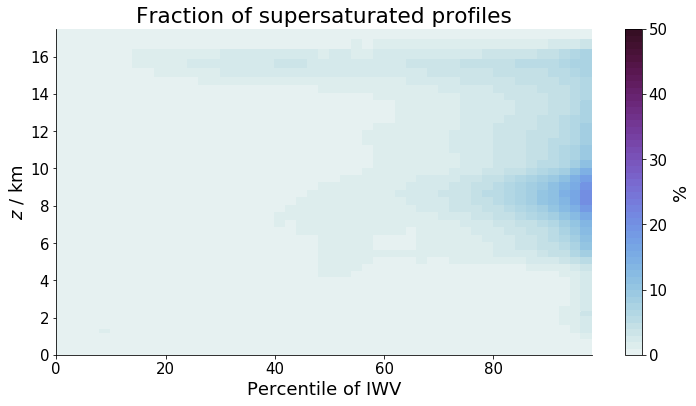

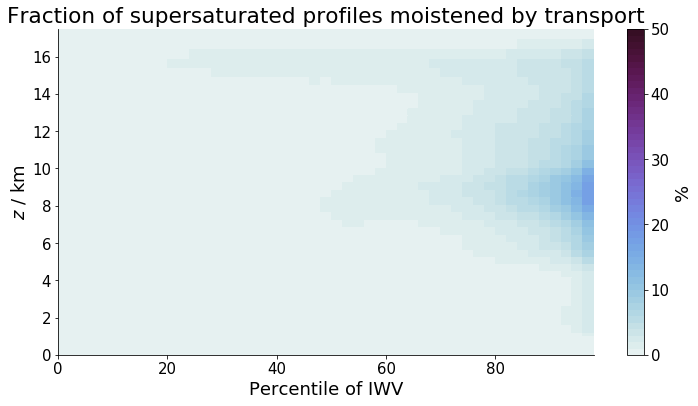

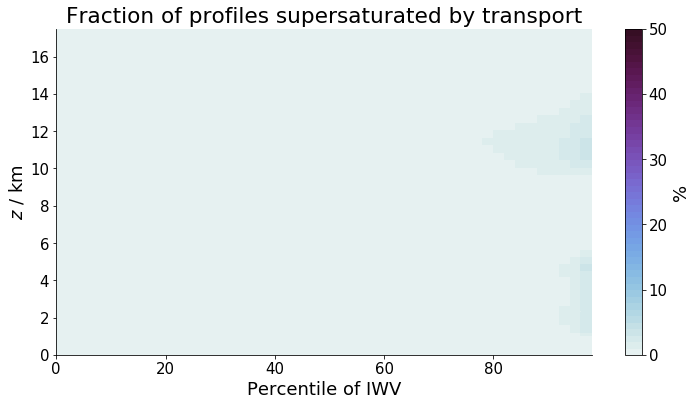

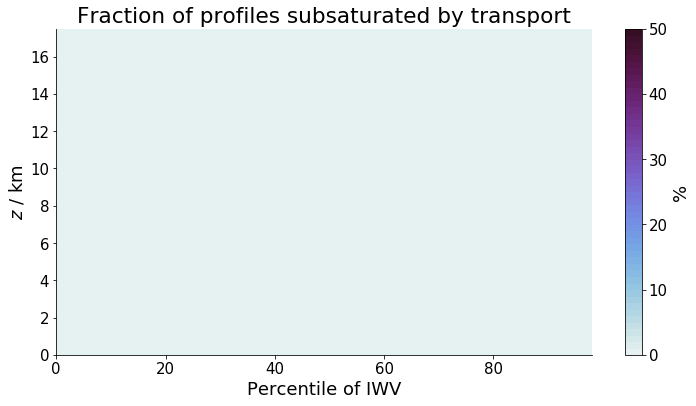

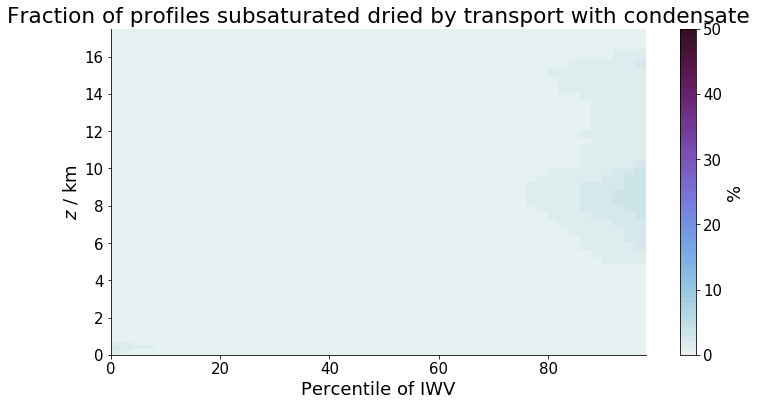

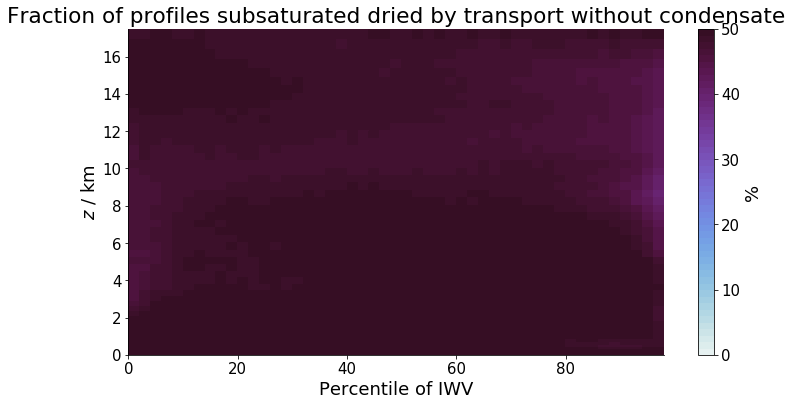

In [91]:
fig, ax = plt.subplots(figsize=(12, 6))
contours = np.arange(-100, 101, 10)
im = ax.pcolor(np.arange(num_percs) * 2, height * 1e-3, supersat_perc.T * 100, cmap=plt.get_cmap('density', 50),
              vmin=0, vmax=50)
ax.set_ylim(0, 17.5)
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('$z$ / km')
ax.set_title(f'Fraction of supersaturated profiles')
fig.colorbar(im, label='%')

fig, ax = plt.subplots(figsize=(12, 6))
contours = np.arange(-100, 101, 10)
im = ax.pcolor(np.arange(num_percs) * 2, height * 1e-3, moistening_supersat_perc.T * 100, cmap=plt.get_cmap('density', 50),
              vmin=0, vmax=50)
ax.set_ylim(0, 17.5)
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('$z$ / km')
ax.set_title(f'Fraction of supersaturated profiles moistened by transport')
fig.colorbar(im, label='%')

fig, ax = plt.subplots(figsize=(12, 6))
contours = np.arange(-100, 101, 10)
im = ax.pcolor(np.arange(num_percs) * 2, height * 1e-3, moistening_supersat_by_transp_perc.T * 100, cmap=plt.get_cmap('density', 50),
              vmin=0, vmax=50)
ax.set_ylim(0, 17.5)
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('$z$ / km')
ax.set_title(f'Fraction of profiles supersaturated by transport')
fig.colorbar(im, label='%')

fig, ax = plt.subplots(figsize=(12, 6))
contours = np.arange(-100, 101, 10)
im = ax.pcolor(np.arange(num_percs) * 2, height * 1e-3, drying_subsat_by_transp_perc.T * 100, cmap=plt.get_cmap('density', 50),
              vmin=0, vmax=50)
ax.set_ylim(0, 17.5)
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('$z$ / km')
ax.set_title(f'Fraction of profiles subsaturated by transport')
fig.colorbar(im, label='%')

fig, ax = plt.subplots(figsize=(12, 6))
contours = np.arange(-100, 101, 10)
im = ax.pcolor(np.arange(num_percs) * 2, height * 1e-3, drying_subsat_cond_perc.T * 100, cmap=plt.get_cmap('density', 50),
              vmin=0, vmax=50)
ax.set_ylim(0, 17.5)
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('$z$ / km')
ax.set_title(f'Fraction of profiles subsaturated dried by transport with condensate')
fig.colorbar(im, label='%')

fig, ax = plt.subplots(figsize=(12, 6))
contours = np.arange(-100, 101, 10)
im = ax.pcolor(np.arange(num_percs) * 2, height * 1e-3, drying_subsat_no_cond_perc.T * 100, cmap=plt.get_cmap('density', 50),
              vmin=0, vmax=50)
ax.set_ylim(0, 17.5)
ax.set_xlabel('Percentile of IWV')
ax.set_ylabel('$z$ / km')
ax.set_title(f'Fraction of profiles subsaturated dried by transport without condensate')
fig.colorbar(im, label='%')

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


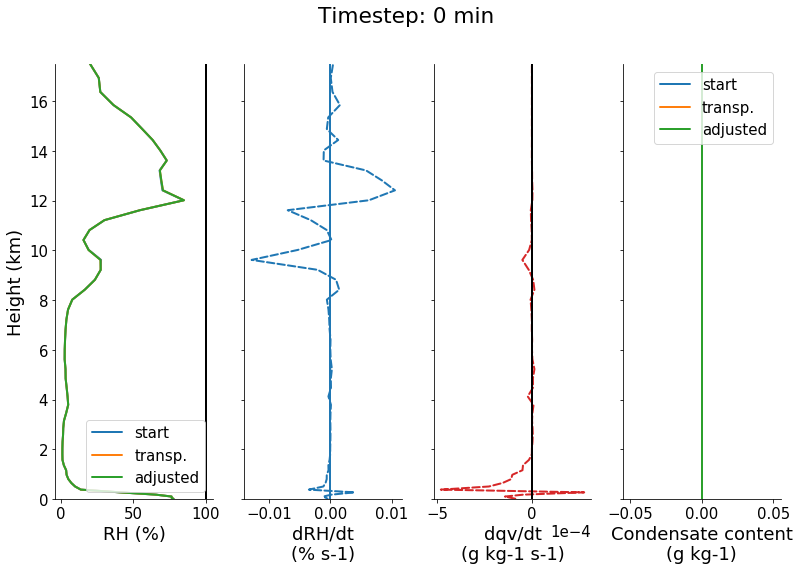

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(13, 8), sharey=True)
num_profiles = profiles['RH'].shape[1]
#high_cond = np.where(dr_dt)
selected = np.where(dr_dt[42]*1e2 < -0.5)[0]
n = 203
ax[0].plot([100, 100], [0, 17.5], color='k')
ax[0].plot(profiles['RH'][:, n] * 1e2, height * 1e-3, label='start', color='C0')
ax[0].plot(rh_transp[:, n] * 1e2, height * 1e-3, label='transp.', color='C1')
ax[0].plot(rh_adjusted[:, n] * 1e2, height * 1e-3, label='adjusted', color='C2')

ax[1].plot([0, 0], [0, 17.5], color='k')
ax[1].plot(dr_dt[:, n] * 1e2, height * 1e-3, color='C0')
ax[1].plot(dr_dt_transp[:, n] * 1e2, height * 1e-3, '--', color='C0')
ax[3].plot(qic_tot[:, n] * 1e3, height * 1e-3, label='start', color='C0')
ax[3].plot(qic_transp[:, n] * 1e3, height * 1e-3, label='transp.', color='C1')
ax[3].plot(qic_adjusted[:, n] * 1e3, height * 1e-3, label='adjusted', color='C2')
ax[2].plot(dq_dt[:, n] * 1e3, height * 1e-3, color='C3')
ax[2].plot(dq_dt_transp[:, n] * 1e3, height * 1e-3, '--', color='C3')
ax[2].plot([0, 0], [0, 17.5], color='k')
ax[0].set_ylim(0, 17.5)
ax[0].legend()
ax[3].legend()
ax[0].set_ylabel('Height (km)')
ax[0].set_xlabel('RH (%)')
ax[1].set_xlabel('dRH/dt\n(% s-1)')
ax[2].set_xlabel('dqv/dt\n(g kg-1 s-1)')
ax[3].set_xlabel('Condensate content\n(g kg-1)')
#ax[2].set_xlim(-0.001, 0.001)
#ax[3].set_xlim(0, 0.002)
fig.suptitle(f'Timestep: {dt // 60} min')
plt.savefig('plots_seminar/saturation_adjustment_example.pdf', dpi=300)

NameError: name 'rh_new' is not defined

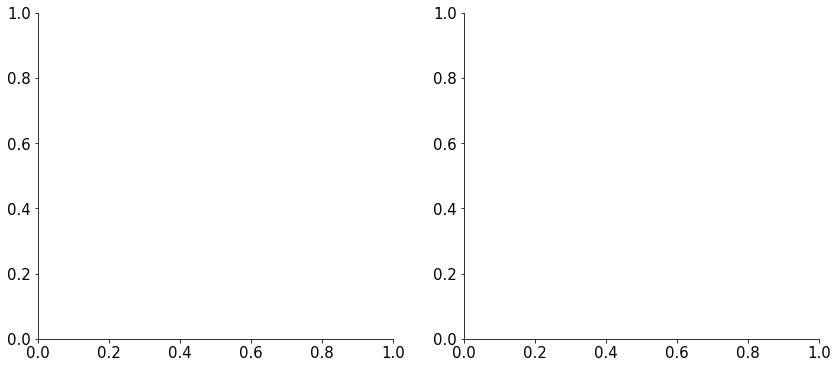

In [33]:
h = 5000
h_ind = np.argmin(np.abs(height - h))
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

num_profiles = profiles['RH'].shape[1]
higher_after_adj = rh_adjusted[h_ind] > rh_new[h_ind]
lower_after_adj = rh_adjusted[h_ind] <= rh_new[h_ind]
perc_higher = np.round(np.sum(higher_after_adj) / num_profiles * 100)
perc_lower = np.round(np.sum(lower_after_adj) / num_profiles * 100)
c_evap = qic_adjusted[h_ind] == 0.0


ax[0].scatter(rh_new[h_ind][higher_after_adj] * 1e2, qic_new[h_ind][higher_after_adj] * 1e3, s=1, label=f'dRH/dt > 0 ({perc_higher}%)')
ax[0].scatter(rh_new[h_ind][lower_after_adj] * 1e2, qic_new[h_ind][lower_after_adj] * 1e3, s=1, label=f'dRH/dt <= 0 ({perc_lower}%)')
#ax[0].scatter(rh_new[h_ind][c_evap] * 1e2, qic_new[h_ind][c_evap] * 1e3, s=1, color='C3')
ax[0].plot([100, 100], [-0.1, 2], lw=0.75, color='k')
#ax[0].plot([-2, 102], [0.01, 0.01], lw=0.75, color='k')

ax[1].scatter(rh_adjusted[h_ind][higher_after_adj] * 1e2, qic_adjusted[h_ind][higher_after_adj] * 1e3, s=1, label=f'dRH/dt > 0 ({perc_higher}%)')
ax[1].scatter(rh_adjusted[h_ind][lower_after_adj] * 1e2, qic_adjusted[h_ind][lower_after_adj] * 1e3, s=1, label=f'dRH/dt <= 0 ({perc_lower}%)')

ax[0].set_title(f'Level: {np.round(height[h_ind] / 1000, 1)}km')
ax[0].set_xlabel('RH$_{transp.}$ / %')
ax[0].set_ylabel('QC$_{transp.}$ / (g kg-1)')
ax[0].set_xlim(0, 120)
ax[0].set_ylim(-0.01, 2.)
ax[0].legend()

ax[1].set_xlabel('RH$_{adjusted}$ / %')
ax[1].set_ylabel('QC$_{adjusted}$ / (g kg-1)')
ax[1].set_xlim(0, 120)
ax[1].set_ylim(-0.01, 2.)

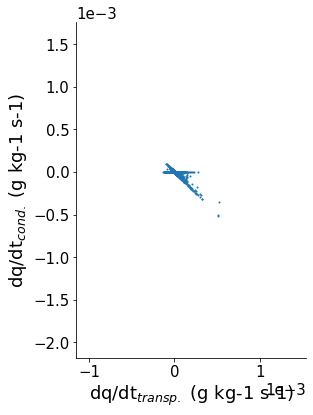

In [86]:
h = 14000
h_ind = np.argmin(np.abs(height - h))
fig, ax = plt.subplots()
sat_by_transp = np.logical_and(profiles['RH'][h_ind]>1, rh_new[h_ind] >0)
ax.scatter(dq_dt_transp[h_ind] * 1e3, dq_dt[h_ind] * 1e3, s=1)
#ax.scatter(dq_dt_transp[h_ind][sat_by_transp] * 1e3, dq_dt[h_ind][sat_by_transp] * 1e3, s=1)
#ax.plot([0, 0], [-0.5, 0.5], lw=0.75, color='k')
#ax.plot([-0.5, 0.5], [0, 0], lw=0.75, color='k')
#ax.scatter(dr_dt_transp[h_ind][lower_after_adj] * 1e2, dr_dt[h_ind][lower_after_adj] * 1e2, s=1)
#ax.annotate(np.nanmean(dr_dt[h_ind]) * 1e2, (0, 0.2))
#ax.plot([-5, 5], [5, -5])
ax.set_xlabel('dq/dt$_{transp.}$ (g kg-1 s-1)')
ax.set_ylabel('dq/dt$_{cond.}$ (g kg-1 s-1)')
ax.set_aspect('equal')

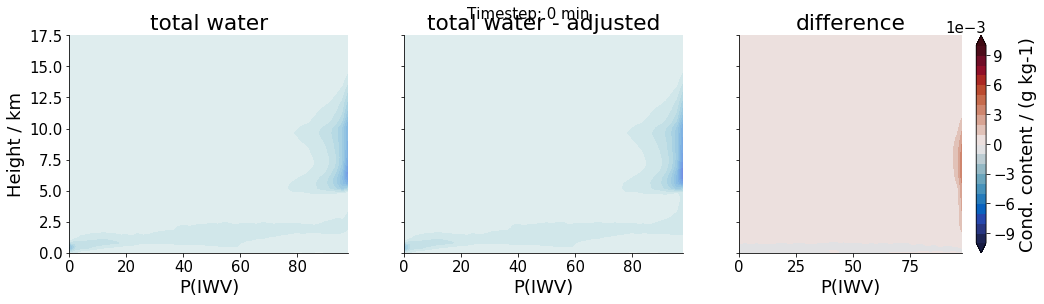

In [92]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(17, 4))
ax[0].contourf(np.arange(num_percs) * 2, height * 1e-3, qic_mean.T * 1e3, np.arange(0, 0.08, 0.0025), cmap='density', extend='both')
ax[1].contourf(np.arange(num_percs) * 2, height * 1e-3, qic_adjusted_mean.T * 1e3, np.arange(0, 0.08, 0.0025), cmap='density', extend='both')
im = ax[2].contourf(np.arange(num_percs) * 2, height * 1e-3, (qic_adjusted_mean.T - qic_mean.T) * 1e3, np.arange(-0.01, 0.01001, 0.001), cmap='difference', extend='both')

ax[0].set_ylim(0, 17.5)
ax[0].set_title('total water')
ax[1].set_title('total water - adjusted')
ax[2].set_title('difference')
ax[0].set_ylabel('Height / km')
ax[0].set_xlabel('P(IWV)')
ax[1].set_xlabel('P(IWV)')
ax[2].set_xlabel('P(IWV)')
fig.suptitle(f'Timestep: {dt // 60} min', fontsize=15)
fig.colorbar(im, label='Cond. content / (g kg-1)')

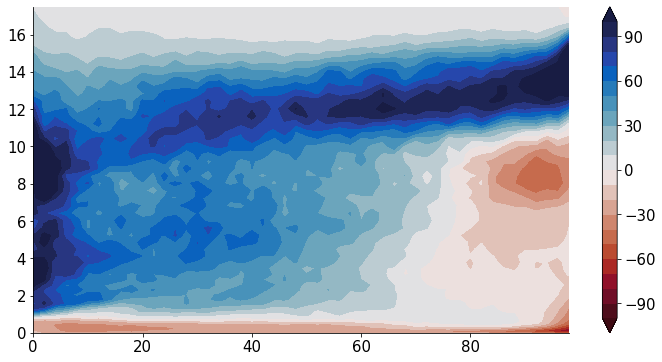

In [147]:
fig, ax = plt.subplots(figsize=(12, 6))
contours = np.arange(-100, 101, 10)
im = ax.contourf(np.arange(num_percs) * 2, height * 1e-3, aqvh_mean.T/q_mean.T* 1e2 * 24 * 60 * 60, contours, cmap='difference_r', extend='both')
ax.set_ylim(0, 17.5)
fig.colorbar(im)

Are profiles with strong downdrafts at around 5km those with a lot of rain?